## CPSC 533V: Assignment 2 - Tabular Q Learning

<p style="font-size: 1.2em;">Due Date: Wed Oct 6, 2021</p>
<p style="font-size: 1.2em;">100 Points Total (9% of final grade)</p>

## Important Notes

* Your deliverable is this Jupyter Notebook. Submission will be done via Canvas.
* For instructions on installing and running Jupyter Notebook: https://jupyter.org/install
    * Start by cloning this repository: git clone git@github.com:UBCMOCCA/CPSC533V_2021W1.git
    * Install Jupyter Notebook using either `conda install jupyter` or `pip install jupyter`
    * Inside the `a2` folder, run `jupyter notebook` and a webpage should open in the browser
    * If not, follow the instruction in terminal to launch an interactive session
* If you use additional Python packages, please list them  as it will help with grading. 
* **We recommend working in groups of two**. List your names and student numbers below (if you use a different name on Canvas).

<ul style="list-style-type: none; font-size: 1.2em;">
<li>Justice Sefas 38416574</li>
</ul>


## Debugging Tips

* Debugging in Jupyter Notebook can be using `pdb` or `ipdb`
* Insert `import ipdb; ipdb.set_trace()` to where you want to set a breakpoint
* See https://docs.python.org/3/library/pdb.html#debugger-commands for useful commands
* Remember to quit out from an `ipdb` session, otherwise you may wonder why a code cell is taking forever to complete 😉

---

##  Tabular Q-Learning

Tabular Q-learning is an RL algorithm for problems with discrete states and discrete actions. The algorithm is described in the class notes, which borrows the summary description from [Section 6.5](http://incompleteideas.net/book/RLbook2018.pdf#page=153) of Richard Sutton's RL book. In the tabular approach, the Q-value is represented as a lookup table. As discussed in class, Q-learning can further be extended to continuous states and discrete actions, leading to the [Atari DQN](https://arxiv.org/abs/1312.5602) / Deep Q-learning algorithm.  However, it is important and informative to first fully understand tabular Q-learning.

Informally, Q-learning works as follows: The goal is to learn the optimal Q-function: 
`Q(s,a)`, which is the *value* of being at state `s` and taking action `a`.  Q tells you how well you expect to do, on average, from here on out, given that you act optimally.  Once the Q function is learned, choosing an optimal action is as simple as looping over all possible actions and choosing the one with the highest Q (optimal action $a^* = \text{max}_a Q(s,a)$).  To learn Q, we initialize it arbitrarily and then iteratively refine it using the Bellman backup equation for Q functions, namely: 
$Q(s,a) \leftarrow Q(s,a) + \alpha [r + \gamma \text{max}_a Q(s', a) - Q(s,a)]$.
Here, $r$ is the reward associated with with the transition from state s to s', and $\alpha$ is a learning rate.

In this assignment you will implement tabular Q-learning and apply it to CartPole – an environment with a **continuous** state space.  To apply the tabular method, **you will need to discretize the CartPole state space** by dividing the state-space into bins.


**Assignment goals:**
- To become familiar with Python, NumPy, and OpenAI Gym
- To understand and implement tabular Q-learning
- To experiment tabular Q-learning on your implemention of discrete CartPole environment
- (Optional) To develop further intuition regarding possible variations of the algorithm

## Introduction
Deep reinforcement learning has generated impressive results for board games ([Go][go], [Chess/Shogi][chess]), video games ([Atari][atari], , [DOTA2][dota], [StarCraft II][scii]), [and][baoding] [robotic][rubix] [control][anymal] ([of][cassie] [course][mimic] 😉).  RL is beginning to work for an increasing range of tasks and capabilities.  At the same time, there are many [gaping holes][irpan] and [difficulties][amid] in applying these methods. Understanding deep RL is important if you wish to have a good grasp of the modern landscape of control methods.

These next several assignments are designed to get you started with deep reinforcement learning, to give you a more close and personal understanding of the methods, and to provide you with a good starting point from which you can branch out into topics of interest. You will implement basic versions of some of the important fundamental algorithms in this space, including Q-learning, policy gradient, and search methods.

We will only have time to cover a subset of methods and ideas in this space.
If you want to dig deeper, we suggest following the links given on the course webpage.  Additionally we draw special attention to the [Sutton book](http://incompleteideas.net/book/RLbook2018.pdf) for RL fundamentals and in depth coverage, and OpenAI's [Spinning Up resources](https://spinningup.openai.com/en/latest/spinningup/rl_intro.html) for a concise intro to RL and deep RL concepts, as well as good comparisons and implementations of modern deep RL algorithms.


[atari]: https://arxiv.org/abs/1312.5602
[go]: https://deepmind.com/research/case-studies/alphago-the-story-so-far
[chess]:https://deepmind.com/blog/article/alphazero-shedding-new-light-grand-games-chess-shogi-and-go 
[dota]: https://openai.com/blog/openai-five/
[scii]: https://deepmind.com/blog/article/AlphaStar-Grandmaster-level-in-StarCraft-II-using-multi-agent-reinforcement-learning
[baoding]: https://bair.berkeley.edu/blog/2019/09/30/deep-dynamics/
[rubix]: https://openai.com/blog/solving-rubiks-cube/
[cassie]: https://www.cs.ubc.ca/~van/papers/2019-CORL-cassie/index.html
[mimic]: https://www.cs.ubc.ca/~van/papers/2018-TOG-deepMimic/index.html
[anymal]: https://arxiv.org/abs/1901.08652


[irpan]: https://www.alexirpan.com/2018/02/14/rl-hard.html
[amid]: http://amid.fish/reproducing-deep-rl



In [58]:
# Install dependencies
# Only run if necessary
!pip install gym
!pip install numpy
!pip install matplotlib
!pip install pyglet
!pip install bottleneck

     |████████████████████████████████| 88 kB 3.1 MB/s eta 0:00:011
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for bottleneck: filename=Bottleneck-1.3.2-cp38-cp38-linux_x86_64.whl size=361727 sha256=d00da738930a47649cd4ac033d0ee5c87e34b35aaf18e806415d032fa6f84665
  Stored in directory: /home/jsefas/.cache/pip/wheels/29/60/c9/98f744fb5c7d1ffb38d096318d9e873a08c0f5df07d6487626
Successfully built bottleneck


In [1]:
import time
import itertools
import numpy as np
import gym

---

## 1. Explore the CartPole environment [18 pts]

Your first task is to familiarize yourself with the OpenAI gym interface and the [CartPole environment]( https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py)
by writing a simple hand-coded policy to try to solve it.  
Read this brief introduction on [OpenAI Gym](https://gym.openai.com/docs/) to get started. 
The gym interface is very popular and you will see many algorithm implementations and 
custom environments that support it.  You may even want to use the API in your course projects, 
to define a custom environment for a task you want to solve.

Below is some example code that runs a simple random policy.  You are to:
- **run the code to see what it does**
- **write code that chooses an action based on the observation**.  You will need to learn about the gym API and to read the CartPole documentation to figure out what the `action` and `obs` vectors mean for this environment. 
Your hand-coded policy can be arbitrary, and it should ideally do better than the random policy.  There is no single correct answer. The goal is to become familiar with `env`s.
- **write code to print out the total reward gained by your policy in a single episode run**
- **answer the short-response questions below** (see the TODOs for all of this)

In [20]:
env = gym.make('CartPole-v1')  # you can also try LunarLander-v2, but make sure to change it back
print('observation space:', env.observation_space)
print('action space:', env.action_space)

# To find out what the observations mean, read the CartPole documentation.
# Uncomment the lines below, or visit the source file: 
# https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py

#cartpole = env.unwrapped
#cartpole?

observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space: Discrete(2)


**1.1 [10pts] Complete the `TODO`s in the next code block**

In [5]:
# Q1.1

# Runs a single episode and render it
# Try running this before editing anything

obs = env.reset()  # get initial state/observation
rewards = 0

while True:
    # TODO: replace this `action` with something that depends on `obs` 
    action = int(obs[3] > 0)
    obs, reward, done, info = env.step(action)
    rewards += reward
    
    env.render()
    time.sleep(0.1)  # so it doesn't render too quickly
    if done: break
env.close()
print(rewards)
# TODO: print out your total sum of rewards here

222.0


**1.2. [2pts] Describe the observation and action spaces of CartPole.  What does each of the values mean/do?**

*Hint: Look at the full [source code here](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py) if you haven't already.*


The first element of the observation space is a vector containing the lower bounds of cart position, velocity, pole angle, velocity; the second element is a vector containing their upper bounds, the third element contains the number of elements observed, the fourth element contains the type of the values in the space.

**1.3. [2pts] What distribution is used to sample initial states? (see the `reset` function)** 

Uniform

**1.4. [2pts] What is the termination condition, which determines if the `env` is `done`?** 

Pole Angle is more than 12 degrees or
Cart Position is more than 2.4 (center of the cart reaches the edge of the display). or
Episode length is greater than 200.

Solved Requirements:
Considered solved when the average return is greater than or equal to 195.0 over 100 consecutive trials.

**1.5. [2pts] Briefly describe your policy.  What observation information does it use?  What score did you achieve (rough maximum and average)?  And how does it compare to the random policy?**

The policy pushes the cart right if the angle of the pole with the normal to the cart is positive (i.e. the pole is falling right) and the policy pushes the cart left otherwise.

---

## 2. Discretize the environment [32 pts]

Next, we need to discretize CartPole's continuous state space to work for tabular Q-learning.  While this is in part  a contrived usage of tabular methods, given the existence of other approaches that are designed to cope with continuous state-spaces, it is also interesting to consider whether tabular methods can be adapted more directly via discretization of the state into bins. Furthermore, tabular methods are simple, interpretabile, and can be proved to converge, and thus they still remain relevant.

Your task is to discretize the state/observation space so that it is compatible with tabular Q-learning.  To do this:
- **implement `obs_normalizer` to pass its test**
- **implement `get_bins` to pass its test**
- **then answer questions 2.3 and 2.4**

[map]: https://arxiv.org/abs/1504.04909
[qd]: https://quality-diversity.github.io/

**2.1 [15pts for passing test_normed]** Normalize observation space

In [42]:
# Q2.1

obs_high = np.asarray([4.8, 2, 0.418, 2])
obs_low = np.asarray([-4.8, -2, -0.418, -2])
def obs_normalizer(obs):
    """Normalize the observations between 0 and 1
    
    If the observation has extremely large bounds, then clip to a reasonable range before normalizing; 
    (-2,2) should work.  (It is ok if the solution is specific to CartPole)
    
    Args:
        obs (np.ndarray): shape (4,) containing an observation from CartPole using the bound of the env
    Returns:
        normed (np.ndarray): shape (4,) where all elements are roughly uniformly mapped to the range [0, 1]
    
    """
    # HINT: check out env.observation_space.high, env.observation_space.low
    
    return (obs - obs_low) / (obs_high - obs_low)

In [43]:
### TEST 2.1
def test_normed():
    obs = env.reset()
    while True:
        obs, _, done, _ =  env.step(env.action_space.sample())
        normed = obs_normalizer(obs) 
        assert np.all(normed >= 0.0) and np.all(normed <= 1.0), '{} are outside of (0,1)'.format(normed)
        if done: break
    env.close()
    print('Passed!')
test_normed()

Passed!


**2.2 [13pts for passing test_binned]**

In [44]:
# Q2.2

def get_bins(normed, num_bins):
    """Map normalized observations (0,1) to bin index values (0,num_bins-1)
    
    Args:
        normed (np.ndarray): shape (4,) output from obs_normalizer
        num_bins (int): how many bins to use
    Returns:
        binned (np.ndarray of type np.int): shape (4,) where all elements are values in range [0,num_bins-1]
    """
    
    return np.digitize(normed, np.arange(0,1,1/num_bins))-1


In [45]:
### TEST 2.2
obs = env.reset()
env.close()

def test_binned(num_bins):
    normed = np.array([0.0, 0.2, 0.8, 1.0])
    binned = get_bins(normed, num_bins)
    assert np.all(binned >= 0) and np.all(binned < num_bins), '{} supposed to be between (0, {})'.format(binned, num_bins-1)
    assert binned.dtype == np.int, "You should also make sure to cast your answer to int using np.int() or arr.astype(np.int)" 

test_binned(5)
test_binned(10)
test_binned(50)
print('Passed!')

Passed!


/tmp/ipykernel_35479/3837541887.py:9: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert binned.dtype == np.int, "You should also make sure to cast your answer to int using np.int() or arr.astype(np.int)"


**2.3. [2pts] If your state has 4 values and each is binned into N possible bins, how many bins are needed to represent all unique possible states)?**



N^4

**2.4. [2pts] After discretizing state space, is the dynamics deterministic or non-deterministic? Explain your answer in one to two sentences.**

No, the action deterministically sets the next state from the current state

---

## 3. Solve the env [30 pts] 

Using the pseudocode below and the functions you implemented above, implement tabular Q-learning and use it to solve CartPole.

We provide setup code to initialize the Q-table and give examples of interfacing with it. Write the inner and outer loops to train your algorithm.  These training loops will be similar to those deep RL approaches, so get used to writing them!

The algorithm (excerpted from Section 6.5 of [Sutton's book](http://incompleteideas.net/book/RLbook2018.pdf)) is given below:

![Sutton RL](https://i.imgur.com/mdcWVRL.png)

in summary:
- **implement Q-learning using this pseudocode and the helper code**
- **answer the questions below**
- **run the suggested experiments and otherwise experiment with whatever interests you**

In [65]:
# setup (see last few lines for how to use the Q-table)

# hyper parameters. feel free to change these as desired and experiment with different values
num_bins = 10
alpha = 0.1
gamma = 0.99
log_n = 1000
# epsilon greedy
eps = 0.05  #usage: action = optimal if np.random.rand() > eps else random

obs = env.reset()

# Q-table initialized to zeros.  first 4 dims are state, last dim is for action (0,1) for left,right.
Q = np.zeros([num_bins]*len(obs)+[env.action_space.n])

# helper function to convert observation into a binned state so we can index into our Q-table
obs2bin = lambda obs: tuple(get_bins(obs_normalizer(obs), num_bins=num_bins))

s = obs2bin(obs)

print('Shape of Q Table: ', Q.shape) # you can imagine why tabular learning does not scale very well
print('Original obs {} --> binned {}'.format(obs, s))
print('Value of Q Table at that obs/state value', Q[s])

Shape of Q Table:  (10, 10, 10, 10, 2)
Original obs [ 0.00636628  0.00072832 -0.0169109  -0.00852985] --> binned (5, 5, 4, 4)
Value of Q Table at that obs/state value [0. 0.]


**3.1 [25pts] Implement Q-learning**

In [50]:
# Q3.1

# TODO: implement Q learning, following the pseudo-code above. 
#     - you can follow it almost exactly, but translating things for the gym api and our code used above
#     - make sure to use e-greedy, where e = random about 0.05 percent of the time
#     - make sure to do the S <-- S' step because it can be easy to forget
#     - every log_n steps, you should render your environment and
#       print out the average total episode rewards of the past log_n runs to monitor how your agent trains
#      (your implementation should be able to break at least +150 average reward value, and you can use that 
#       as a breaking condition.  It make take several minutes to run depending on your computer.)

episode_rewards = []
num_episode = -1
prev_rewards = np.zeros(log_n)
while True:
    num_episode = num_episode + 1 if num_episode < log_n - 1 else 0

    obs = env.reset()
    while True:

        action = np.argmax(Q[obs2bin(obs)]) if np.random.rand() > eps else env.action_space.sample()
        
        new_obs, reward, done, info = env.step(action)
        rewards += reward

        Q[obs2bin(obs)][action] += alpha * (reward + gamma*np.max(Q[obs2bin(new_obs)]) - Q[obs2bin(obs)][action])
        
        obs = new_obs
        
        # if num_episode == 0:
        #    env.render()
        #    time.sleep(0.1)  # so it doesn't render too quickly
        if done: break
            
    prev_rewards[num_episode] = rewards
    episode_rewards.append(rewards)
    rewards = 0
    
    if np.mean(prev_rewards) > 150:
        print(np.mean(prev_rewards))
    if np.mean(prev_rewards) > 150: break

9.682
9.837
9.899
9.87
9.914
9.916
26.348
97.774


**3.2 [5pts] Plot the learning curve**

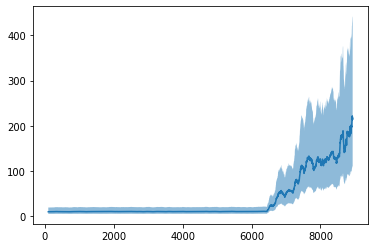

In [63]:
# Q3.2

# TODO: Plot the learning curve.
#       Below is a snippet for generate a curve with upper and lower bounds.
#       From your training loop above, save the episode rewards.
#       Rerun the training code a few times to get min and max.

import matplotlib.pyplot as plt
from bottleneck import move_mean


x = np.arange(len(episode_rewards))
y = episode_rewards

window_size = 100
plt.plot(move_mean(episode_rewards, window_size))

lower_bound = 0.5*np.asarray(move_mean(episode_rewards, window_size))
upper_bound = 2.0*np.asarray(move_mean(episode_rewards, window_size))
plt.fill_between(x, lower_bound, upper_bound, alpha=0.5)



## 4. Experiments [20 pts]

Given a working algorithm, you will run a few experiments.  Either make a copy of your code above to modify, or make the modifications in a way that they can be commented out or switched between (with boolean flag if statements).

**4.2. [10pts] $\epsilon$-greedy.**  How sensitive are the results to the value of $\epsilon$?   First, write down your prediction of what would happen if $\epsilon$ is set to various values, including for example [0, 0.05, 0.25, 0.5].

In [74]:
# Q3.1

# TODO: implement Q learning, following the pseudo-code above. 
#     - you can follow it almost exactly, but translating things for the gym api and our code used above
#     - make sure to use e-greedy, where e = random about 0.05 percent of the time
#     - make sure to do the S <-- S' step because it can be easy to forget
#     - every log_n steps, you should render your environment and
#       print out the average total episode rewards of the past log_n runs to monitor how your agent trains
#      (your implementation should be able to break at least +150 average reward value, and you can use that 
#       as a breaking condition.  It make take several minutes to run depending on your computer.)


for eps in [0.0, 0.05, 0.25, 0.5, 0.8]:
    Q = np.zeros([num_bins]*len(obs)+[env.action_space.n])
    print('eps == {}'.format(eps))
    
    episode_rewards = []
    num_episode = -1
    prev_rewards = np.zeros(log_n)
    for t in range(10*log_n):
        num_episode = num_episode + 1 if num_episode < log_n - 1 else 0

        obs = env.reset()
        while True:

            action = np.argmax(Q[obs2bin(obs)]) if np.random.rand() > eps else env.action_space.sample()

            new_obs, reward, done, info = env.step(action)
            rewards += reward

            Q[obs2bin(obs)][action] += alpha * (reward + gamma*np.max(Q[obs2bin(new_obs)]) - Q[obs2bin(obs)][action])

            obs = new_obs

            # if num_episode == 0:
            #    env.render()
            #    time.sleep(0.1)  # so it doesn't render too quickly
            if done: break

        prev_rewards[num_episode] = rewards
        episode_rewards.append(rewards)
        rewards = 0
        
        if num_episode == log_n - 1:
            print(np.mean(prev_rewards))
        if np.mean(prev_rewards) > 75: break

eps == 0.0
9.37
9.377
9.314
9.354
9.409
9.372
9.328
9.348
9.374
9.368
eps == 0.05
10.099
10.205
10.299
10.305
10.263
10.259
10.332
10.344
10.367
10.312
eps == 0.25
38.732
eps == 0.5
56.775
eps == 0.8
29.367
33.293
34.196
34.136
33.599
34.369
34.679
34.439
33.978
35.31


If eps == 0 then the algorithm would not improve very much since it would not explore new types of actions. It would get stuck in a local maximum and repeat the same actions whenever it's in a given state.

eps == 0.05 probably performs well but not optimally since it does not explore the action space very much

eps == 0.25 probably performs the best as it chooses the best option 3/4 of the time but explores quite often

eps == 0.5 probably explores too much and uses bad actions too often

Now run the experiment and observe the impact on the algorithm.  Report the results below.

The results show that as epsilon increases, so does the speed at which the algorithm learns a good policy, i.e. one that averages more than a reward of 75 across episodes.

**4.3. [10pts] Design your own experiment.** Design a modification that you think would either increase or reduce performance.  A simple example (which you can use) is initializing the Q-table differently, and thinking about how this might alter performance. Write down your idea, what you think might happen, and why.

I think that increasing epsilon to 0.8 will make the algorithm degrade as it tries too many poor actions. I also believe that if we initialized the Q table with the output of a previous run, then it would perform better the second time around even with the same value of eps.

In [84]:
eps = 0.1

Q = np.zeros([num_bins]*len(obs)+[env.action_space.n])
print('eps == {}'.format(eps))

for a in range(2): # the second iteration will have an already updated Q table from the first iteration
    print('iteration {}'.format(a))
    
    episode_rewards = []
    num_episode = -1
    prev_rewards = np.zeros(log_n)
    for t in range(5*log_n):
        num_episode = num_episode + 1 if num_episode < log_n - 1 else 0

        obs = env.reset()
        while True:

            action = np.argmax(Q[obs2bin(obs)]) if np.random.rand() > eps else env.action_space.sample()

            new_obs, reward, done, info = env.step(action)
            rewards += reward

            Q[obs2bin(obs)][action] += alpha * (reward + gamma*np.max(Q[obs2bin(new_obs)]) - Q[obs2bin(obs)][action])

            obs = new_obs

            # if num_episode == 0:
            #    env.render()
            #    time.sleep(0.1)  # so it doesn't render too quickly
            if done: break

        prev_rewards[num_episode] = rewards
        episode_rewards.append(rewards)
        rewards = 0

        if num_episode == log_n - 1:
            print(np.mean(prev_rewards))
        if np.mean(prev_rewards) > 100: break

eps == 0.1
iteration 0
10.624
10.642
12.077
12.386
12.456
iteration 1
12.313
12.394
12.434
21.648
60.02


Run the experiment and report the results.

I did a test for eps = 0.8 to confirm that at some point eps is too large and the algorithm does not perform well. 

We can see that in the first iteration, the algorithm improves very slowly, but the second iteration improves faster and attains higher reward values given a better starting Q table.

---

## A. Extensions (optional)

- does the learning rate make a difference?
- visualize the Q-table to see which values are being updated and not
- design a better binning strategy that uses fewer bins for a better-performing policy
- extend this approach to work on different environments (e.g., LunarLander-v2)
- extend this approach to work on environments with continuous actions, by using a fixed set of discrete samples of the action space.  e.g., for Pendulum-v0
- implement a simple deep learning version of this.  we will see next homework that DQN uses some tricks to make the neural network training more stable.  Experiment directly with simply replacing the Q-table with a Q-Network and train the Q-Network using gradient descent with `loss = (targets - Q(s,a))**2`, where `targets = stop_grad(R + gamma * maxa(Q(s,a))`).